In [2]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['output', 'models'], 'training_data.csv')
file_path_testing_data_parrish = get_data_path(['output', 'models'], 'testing_data_parrish.csv')

supplementary_figure_path = get_data_path(['figures', 'supp_figures'], 'scatter_plot_of_all_features.png')

In [4]:
# load dataframe
df = pd.read_csv(file_path_training_data)
display(df.head())

df_parrish = pd.read_csv(file_path_testing_data_parrish)
display(df_parrish.head())

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False
3,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,-0.241323,0.379455,False
4,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.299715,-0.077118,False


,genepair,A1,A2,A1_entrez,A2_entrez,PC9_GI_score,PC9_GI_fdr,HeLa_GI_score,HeLa_GI_fdr,DepMap_ID,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A2M_PZP,A2M,PZP,2.0,5858.0,0.264313,0.138809,-0.154320,0.424612,ACH-000779,...,0.0,True,122.0,2.97235,0.601651,0.804023,473.357464,-0.249934,0.333503,False
1,A2M_PZP,A2M,PZP,2.0,5858.0,0.264313,0.138809,-0.154320,0.424612,ACH-001086,...,0.0,True,122.0,2.97235,0.601651,0.804023,473.357464,-0.038689,-0.115678,False
2,AADACL3_AADACL4,AADACL3,AADACL4,126767.0,343066.0,-0.000281,0.992873,0.120862,0.433194,ACH-000779,...,0.0,False,0.0,0.00000,0.141775,0.213038,0.350221,0.022368,-0.106713,False
3,AADACL3_AADACL4,AADACL3,AADACL4,126767.0,343066.0,-0.000281,0.992873,0.120862,0.433194,ACH-001086,...,0.0,False,0.0,0.00000,0.141775,0.213038,0.350221,-0.252247,0.257577,False
4,AADAC_AADACL2,AADAC,AADACL2,13.0,344752.0,-0.299150,0.066517,0.016004,0.951159,ACH-000779,...,0.0,False,1.0,0.00000,0.417877,2.854048,9.815447,-0.007339,-0.023724,False


In [ ]:
# remove NA values
features = ['zMaxExp_A1A2', 'zMinExp_A1A2', 'rMaxExp_A1A2', 'rMinExp_A1A2',
            'z_max_ranked_A1A2', 'z_min_ranked_A1A2', 'max_ranked_A1A2', 'min_ranked_A1A2',
            'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 'max_seq_id', 'min_seq_id',
            'ranked_BioGRID_ALL', 'ranked_Essentiality_weighted_PPI', 
            'min_GO_ranked_ess', 'max_GO_ranked_ess', 'smallest_GO_ranked_ess',
            'min_GO_CC_ranked_ess', 'max_GO_CC_ranked_ess', 'smallest_GO_CC_ranked_ess',
            'Expression_weighted_PPI', 
            'max_gene_expression', 'min_gene_expression', 'smallest_gene_expression',
            'min_GO_CC_expression', 'max_GO_CC_expression', 'smallest_GO_CC_expression']

target = 'SL_new'

In [10]:
feature_columns = ['rMaxExp_A1A2', 'rMinExp_A1A2',
                     'max_ranked_A1A2', 'min_ranked_A1A2',
                     'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
                     'min_sequence_identity',
                     'weighted_PPI_essentiality', 'weighted_PPI_expression',
                     'smallest_BP_GO_essentiality', 'smallest_CC_GO_essentiality',
                     'smallest_BP_GO_expression', 'go_CC_expression']


label = ['Gene Expression (max)', 'Gene Expression (min)',
        'Gene Essentiality (max)', 'Gene Essentiality (min)', 
        'Copy Number (max)', 'Copy Number (min)', 
        'Protein Altering Mutation', 'Damaging Mutation', 'Sequence Identity',
        'Essentiality of Shared wPPIs', 'Expression of Shared wPPIs', 
         'GO BP Essentiality (smallest)', 'GO CC Essentiality (smallest)',
         'GO BP Expression (smallest)', 'GO CC Expression (smallest)']

category = ['expression', 'expression', 
            'essentiality', 'essentiality',
            'genomic', 'genomic', 'genomic', 'genomic', 
            'sequence', 'essentiality', 'expression', 'essentiality', 'essentiality', 
             'expression', 'expression']


target_column = 'SL_new'

In [11]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column]
    
    # Define the number of folds for the cross-validation
    n_folds = 5

    # Define the number of repetitions
    n_repeats = 10
    
    # Create a RepeatedStratifiedKFold object
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    # Initialize lists to store the average ROC-AUC and average precision values for each feature
    mean_aucs = []
    mean_prs = []

    # Calculate baseline PR AUC
    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    # Iterate over each feature
    for feature_name in feature_columns:
        # Get the feature data
        feature = data[feature_name].values
        aucs = []
        aps = []

        # Calculate the ROC AUC for both positive and negative directions
        pos_direction = roc_auc_score(target, feature)
        neg_direction = roc_auc_score(target, -feature)

        # If the ROC AUC is higher for the negative direction, then flip the feature
        if neg_direction > pos_direction:
            feature = -feature

        # Perform cross-validation
        for train_index, test_index in rskf.split(feature, target):
            train_target, test_target = target[train_index], target[test_index]
            train_feature, test_feature = feature[train_index], feature[test_index]
            
            # Calculate the ROC AUC for the feature
            auc = roc_auc_score(test_target, test_feature)
            aucs.append(auc)
            
            # Calculate the average precision for the feature
            avg_precision = average_precision_score(test_target, test_feature)
            aps.append(avg_precision)

        mean_auc = np.mean(aucs)
        mean_pr = np.mean(aps)

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_auc}')
        print(f'Average precision for feature {feature_name} over {n_folds * n_repeats} iterations: {mean_pr}')

    # Create a pandas DataFrame from the list of mean ROC AUC values
    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories
    })

    # Sort the DataFrame by 'mean_roc_auc' in descending order
    pred_df = pred_df.sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    # Identify the feature with the maximum ROC AUC and average precision
    max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
    max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]

    print(f'Feature with the maximum ROC AUC value: {max_roc_auc_feature["feature"]}')
    print(f'Maximum ROC AUC value: {max_roc_auc_feature["mean_roc_auc"]}')

    print(f'Feature with the maximum average precision: {max_pr_feature["feature"]}')
    print(f'Maximum precision value: {max_pr_feature["avg_precision"]}')

    return pred_df

In [12]:
pred_df = calculate_predictive_power(df, feature_columns, target_column, label, category)
pred_df

Baseline PR AUC: 0.0232
Mean ROC AUC for feature rMaxExp_A1A2 over 50 iterations: 0.6975958233510194
Average precision for feature rMaxExp_A1A2 over 50 iterations: 0.05552380810001761
Mean ROC AUC for feature rMinExp_A1A2 over 50 iterations: 0.7096655617547215
Average precision for feature rMinExp_A1A2 over 50 iterations: 0.07112569717440005
Mean ROC AUC for feature max_ranked_A1A2 over 50 iterations: 0.7232304817347626
Average precision for feature max_ranked_A1A2 over 50 iterations: 0.09397640984520068
Mean ROC AUC for feature min_ranked_A1A2 over 50 iterations: 0.792498810656365
Average precision for feature min_ranked_A1A2 over 50 iterations: 0.11284611830277474
Mean ROC AUC for feature max_cn over 50 iterations: 0.641530593440297
Average precision for feature max_cn over 50 iterations: 0.055748528587802576
Mean ROC AUC for feature min_cn over 50 iterations: 0.5778135715311222
Average precision for feature min_cn over 50 iterations: 0.04810838516905143
Mean ROC AUC for feature Prot

,feature,mean_roc_auc,avg_precision,label,category
0,min_ranked_A1A2,0.792499,0.112846,Gene Essentiality (min),essentiality
1,max_ranked_A1A2,0.723230,0.093976,Gene Essentiality (max),essentiality
2,rMinExp_A1A2,0.709666,0.071126,Gene Expression (min),expression
3,rMaxExp_A1A2,0.697596,0.055524,Gene Expression (max),expression
4,weighted_PPI_essentiality,0.666001,0.041801,Essentiality of Shared wPPIs,essentiality
5,weighted_PPI_expression,0.657419,0.043151,Expression of Shared wPPIs,expression
6,max_cn,0.641531,0.055749,Copy Number (max),genomic
7,smallest_BP_GO_essentiality,0.606904,0.057082,GO BP Essentiality (smallest),essentiality
8,smallest_BP_GO_expression,0.601744,0.069968,GO BP Expression (smallest),expression
9,min_cn,0.577814,0.048108,Copy Number (min),genomic


In [13]:
pred_parrish_df = calculate_predictive_power(df_parrish, feature_columns, target_column, label, category)
pred_parrish_df

Baseline PR AUC: 0.0782
Mean ROC AUC for feature rMaxExp_A1A2 over 50 iterations: 0.6920000546828768
Average precision for feature rMaxExp_A1A2 over 50 iterations: 0.1513894332122074
Mean ROC AUC for feature rMinExp_A1A2 over 50 iterations: 0.7663967619746761
Average precision for feature rMinExp_A1A2 over 50 iterations: 0.22752690197941677
Mean ROC AUC for feature max_ranked_A1A2 over 50 iterations: 0.6222543672641832
Average precision for feature max_ranked_A1A2 over 50 iterations: 0.14681319727481712
Mean ROC AUC for feature min_ranked_A1A2 over 50 iterations: 0.6357750850830606
Average precision for feature min_ranked_A1A2 over 50 iterations: 0.19224001158092577
Mean ROC AUC for feature max_cn over 50 iterations: 0.5791436184583424
Average precision for feature max_cn over 50 iterations: 0.09820247168894129
Mean ROC AUC for feature min_cn over 50 iterations: 0.571128783418354
Average precision for feature min_cn over 50 iterations: 0.10470890121262683
Mean ROC AUC for feature Prote

,feature,mean_roc_auc,avg_precision,label,category
0,rMinExp_A1A2,0.766397,0.227527,Gene Expression (min),expression
1,weighted_PPI_essentiality,0.730609,0.209490,Essentiality of Shared wPPIs,essentiality
2,weighted_PPI_expression,0.711630,0.184774,Expression of Shared wPPIs,expression
3,rMaxExp_A1A2,0.692000,0.151389,Gene Expression (max),expression
4,smallest_BP_GO_expression,0.648535,0.208319,GO BP Expression (smallest),expression
5,min_ranked_A1A2,0.635775,0.192240,Gene Essentiality (min),essentiality
6,max_ranked_A1A2,0.622254,0.146813,Gene Essentiality (max),essentiality
7,smallest_BP_GO_essentiality,0.619486,0.189972,GO BP Essentiality (smallest),essentiality
8,go_CC_expression,0.606751,0.167460,GO CC Expression (smallest),expression
9,smallest_CC_GO_essentiality,0.599912,0.166408,GO CC Essentiality (smallest),essentiality


In [14]:
# Assuming both DataFrames have a common identifier column, e.g., 'id'
common_column = 'feature'

# Set the index of both DataFrames to the common column
pred_parrish_df.set_index(common_column, inplace=True)
pred_df.set_index(common_column, inplace=True)

# Reindex pred_parrish_df to match the order of pred_df
pred_parrish_df = pred_parrish_df.reindex(pred_df.index)

# Reset the index if needed
pred_parrish_df.reset_index(inplace=True)
pred_df.reset_index(inplace=True)

In [15]:
pred_df

,feature,mean_roc_auc,avg_precision,label,category
0,min_ranked_A1A2,0.792499,0.112846,Gene Essentiality (min),essentiality
1,max_ranked_A1A2,0.723230,0.093976,Gene Essentiality (max),essentiality
2,rMinExp_A1A2,0.709666,0.071126,Gene Expression (min),expression
3,rMaxExp_A1A2,0.697596,0.055524,Gene Expression (max),expression
4,weighted_PPI_essentiality,0.666001,0.041801,Essentiality of Shared wPPIs,essentiality
5,weighted_PPI_expression,0.657419,0.043151,Expression of Shared wPPIs,expression
6,max_cn,0.641531,0.055749,Copy Number (max),genomic
7,smallest_BP_GO_essentiality,0.606904,0.057082,GO BP Essentiality (smallest),essentiality
8,smallest_BP_GO_expression,0.601744,0.069968,GO BP Expression (smallest),expression
9,min_cn,0.577814,0.048108,Copy Number (min),genomic


In [16]:
pred_parrish_df

,feature,mean_roc_auc,avg_precision,label,category
0,min_ranked_A1A2,0.635775,0.192240,Gene Essentiality (min),essentiality
1,max_ranked_A1A2,0.622254,0.146813,Gene Essentiality (max),essentiality
2,rMinExp_A1A2,0.766397,0.227527,Gene Expression (min),expression
3,rMaxExp_A1A2,0.692000,0.151389,Gene Expression (max),expression
4,weighted_PPI_essentiality,0.730609,0.209490,Essentiality of Shared wPPIs,essentiality
5,weighted_PPI_expression,0.711630,0.184774,Expression of Shared wPPIs,expression
6,max_cn,0.579144,0.098202,Copy Number (max),genomic
7,smallest_BP_GO_essentiality,0.619486,0.189972,GO BP Essentiality (smallest),essentiality
8,smallest_BP_GO_expression,0.648535,0.208319,GO BP Expression (smallest),expression
9,min_cn,0.571129,0.104709,Copy Number (min),genomic


In [23]:
# pearson correlation
x = pred_df['mean_roc_auc']
y = pred_parrish_df['mean_roc_auc']
correlation, p_value = pearsonr(x, y)

In [24]:
display(correlation, p_value)

0.6984500942722566

0.003775108849432158

In [19]:
# spearman correlation
x = pred_df['mean_roc_auc']
y = pred_parrish_df['mean_roc_auc']
correlation, p_value = spearmanr(x, y)

In [20]:
display(correlation, p_value)

0.7892857142857141

0.0004673267561781759

In [21]:
colors = ["#009E73", "#56B4E9", '#0072B2', "#E69F00"]

# Map categorical values to integers
category_mapping = {category: idx for idx, category in enumerate(pred_df['category'].unique())}
pred_df['category_int'] = pred_df['category'].map(category_mapping)

point_colors = pred_df['category_int'].map(lambda val: colors[val % len(colors)])

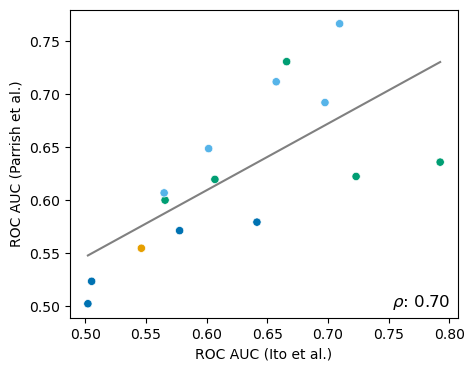

In [26]:
# Create a scatterplot with a regression line
fig, ax = plt.subplots(figsize=(5, 4))
#sns.scatterplot(x=x, y=y, color='#0072B2', ax=ax, legend=False)#hue=point_colors, palette=colors, legend=False)
sns.scatterplot(x=x, y=y, ax=ax, hue=point_colors, palette=colors, legend=False)
#sns.regplot(x=x, y=y, fit_reg=True, scatter=False, color='grey')  # Add regression line

# Calculate and plot regression line for the full dataset
slope, intercept = np.polyfit(x, y, 1)
ax.plot(x, slope * x + intercept, color='grey')

ax.text(0.98, 0.02, f'$\\rho$: {correlation:.2f}', transform=ax.transAxes, fontsize=12, verticalalignment='bottom', horizontalalignment='right')


plt.xlabel('ROC AUC (Ito et al.)')
plt.ylabel('ROC AUC (Parrish et al.)')
plt.show()

fig.savefig(supplementary_figure_path, bbox_inches='tight', dpi=500)